In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
sys.path.append('../external/hovernet')
sys.path.append('../deconvplugin')

import json
import os
import pickle
import torch
import scanpy as sc

PATH = '/home/luca/Documents/data/'

#'/cluster/CBIO/data1/lgortana/'
#'/home/luca/Documents/data/'

# HEDeST predictions

## Load data

In [40]:
# names
adata_name = 'Xenium_FFPE_Human_Breast_Cancer_Rep1'
sim_tag = 'real'

In [41]:
import pandas as pd

data_path = os.path.join(PATH, adata_name)
sim_path = os.path.join(data_path, "sim")

#load images
image_path = os.path.join(data_path, 'pyr_tif', 'Xenium_FFPE_Human_Breast_Cancer_Rep1_he_image.tif')
image_dict = torch.load(os.path.join(sim_path, 'image_dict_64.pt'))

#load ground truth
ground_truth = pd.read_csv(os.path.join(sim_path, f'sim_{adata_name}_gt.csv'), index_col=0)
ground_truth.index = ground_truth.index.astype(str)

In [42]:
#load adata
path_ST_adata = os.path.join(sim_path, f"pseudo_adata_{sim_tag}.h5ad")
adata = sc.read_h5ad(path_ST_adata)

#load spot_dict
path_spot_dict = os.path.join(sim_path, f'spot_dict_{sim_tag}.json')
with open(path_spot_dict, 'r') as f:
    spot_dict = json.load(f)

#load proportions
spot_prop_df = pd.read_csv(os.path.join(sim_path, f'sim_{adata_name}_prop_{sim_tag}.csv'), index_col=0)
spot_prop_df.index = spot_prop_df.index.astype(str)
ct_list = list(spot_prop_df.columns)

#load segmentation
json_path = os.path.join(sim_path, "pannuke_fast_mask_lvl3_annotated.json")
with open(json_path) as json_file:
    hovernet_dict = json.load(json_file)

An important thing to define is the color dictionnary, you can generate it automatically with the generate_color_dict function in basics file, or you can make your own. For visualization purposes, I manually created the dictionnary so cell types from a same subgroup have similar colors (e.g. T cells and B cells).

In [43]:
#color_dict annotated hovernet
color_dict = {
    '0': ['Tumor_Cells', [31, 119, 180, 255]],
    '1': ['Macrophages', [0, 170, 140, 255]],
    '2': ['Stromal_Cells', [255, 140, 0, 255]],
    '3': ['Myoepithelial_Cells', [255, 220, 100, 255]],
    '4': ['T_Cells', [0, 150, 0, 255]],
    '5': ['Endothelial_Cells', [230, 90, 60, 255]],
    '6': ['B_Cells', [200, 255, 200, 255]]
}

# color_dict = {
#     '0': ['neopla', [31, 119, 180, 255]],
#     '1': ['inflam', [0, 170, 140, 255]],
#     '2': ['connec', [255, 140, 0, 255]]
# }

color_dict_all = color_dict.copy()
color_dict_all[f'{len(ct_list)}'] = ['unlabeled', [0, 0, 0, 255]]
color_dict_all[f'{len(ct_list)+1}'] = ['no_match', [170, 170, 170, 255]]

## Ground truth

In [44]:
from deconvplugin.analysis.postseg import StdVisualizer

plotter_gt = StdVisualizer(image_path=image_path,
                           adata=adata,
                           adata_name=adata_name,
                           seg_dict=hovernet_dict,
                           color_dict=color_dict_all)

Visium data found.


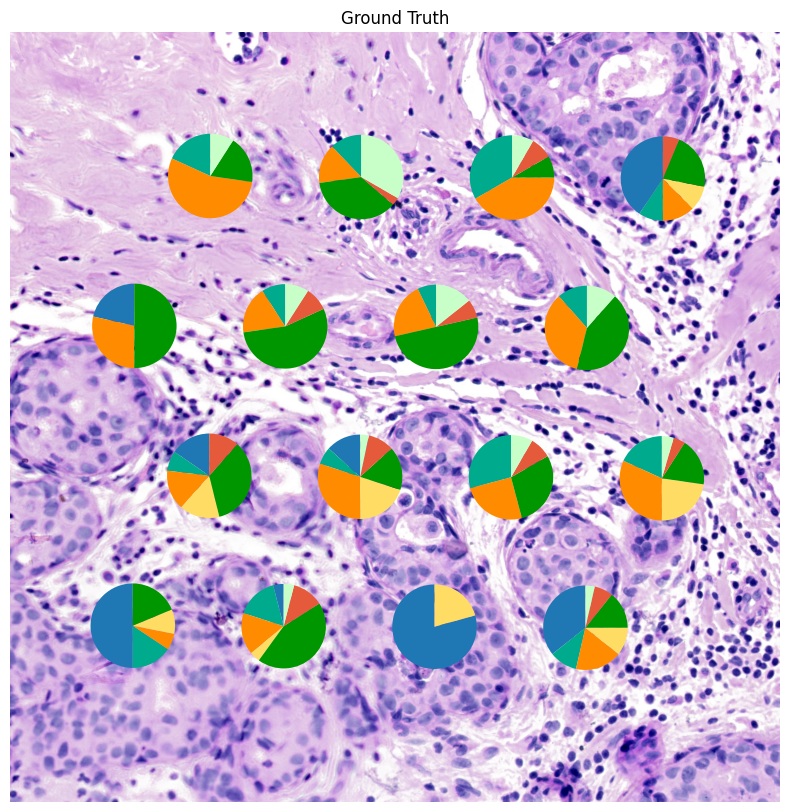

In [45]:
window = ((17000, 17000), (1500, 1500)) #((3000, 20000), (2000, 2000))
plotter_gt.plot_slide(window=window, spot_prop_df=spot_prop_df, show_visium=True, title='Ground Truth', display=False, figsize=(10, 10))
# fig.savefig(f"results/HistoCell/{adata_name}/fig/crop_7_types_gt_{window[0][0]}_{window[0][1]}_{window[1][0]}_prop.png", dpi=300, bbox_inches='tight')

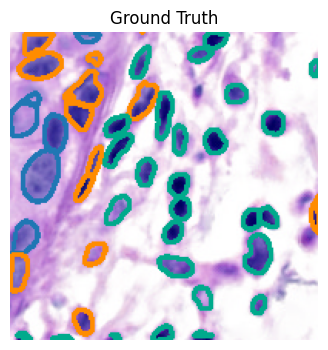

In [16]:
window = ((18285, 17090), (200, 200)) #((3000, 20000), (2000, 2000))
plotter_gt.plot_seg(window=window, show_visium=False, title='Ground Truth', display=True, figsize=(4, 4))
# fig.savefig(f"results/HistoCell/{adata_name}/fig/crop_3_types_gt_{window[0][0]}_{window[0][1]}_{window[1][0]}.png", dpi=300, bbox_inches='tight')

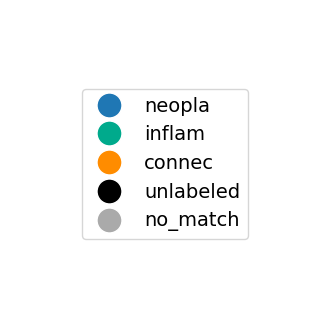

In [17]:
from deconvplugin.analysis.plots import plot_legend

plot_legend(color_dict_all)

## Model predictions

In [22]:
#load model infos
model_tag = 'model_quick_alpha_0.0_lr_0.0003_weights_False_divergence_l2_beta_1.0_seed_5'
model_dir = os.path.join('results/HistoCell/Xenium_FFPE_Human_Breast_Cancer_Rep1/HEDeST/3types', model_tag)

with open(os.path.join(model_dir, 'info.pickle'), 'rb') as f:
    model_info = pickle.load(f)

In [23]:
from deconvplugin.analysis.pred_analyzer import PredAnalyzer

analyzer_dp = PredAnalyzer(model_info=model_info,
                           adjusted=True,
                           ground_truth=ground_truth, 
                           image_dict=image_dict
                           )

Loading predicted labels...
Loading true labels...
Use `add_attributes(seg_dict=your_seg_dict)` to add one.


In [17]:
analyzer_dp.add_attributes(adata=adata,
                           adata_name=adata_name,
                           image_path=image_path,
                           seg_dict=hovernet_dict)

In [18]:
from deconvplugin.analysis.postseg import StdVisualizer

plotter_dp = StdVisualizer(image_path, 
                           adata, 
                           adata_name, 
                           seg_dict=analyzer_dp.seg_dict_w_class,
                           color_dict=color_dict)

Visium data found.


In [43]:
window = ((18285, 17090), (200, 200))
fig = plotter_dp.plot_seg(window=window, show_visium=False, display=False, title="HEDeST", figsize=(4, 4))
fig.savefig(f"results/HistoCell/{adata_name}/fig/crop_3_types_hedest_{window[0][0]}_{window[0][1]}_{window[1][0]}.png", dpi=300, bbox_inches='tight')

In [ ]:
window = ((18050, 18100), (200, 200)) #((3000, 20000), (2000, 2000))
plotter_dp.plot_slide(window=window, spot_prop_df=analyzer_dp.predicted_proportions, show_visium=True, title='HEDeST', display=False, figsize=(10, 10))
# fig.savefig(f"results/HistoCell/{adata_name}/fig/crop_7_types_hedest_{window[0][0]}_{window[0][1]}_{window[1][0]}_prop.png", dpi=300, bbox_inches='tight')

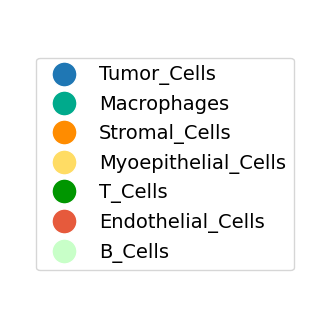

In [303]:
plot_legend(color_dict, savefig=f"results/HistoCell/{adata_name}/fig/legend_7_types.png")

# HistoCell predictions

## Load data

In [46]:
slide_name = 'Rep1_256_hires'
seed = 5

In [47]:
#load predictions
histocell_pred = pd.read_csv(f'results/HistoCell/{adata_name}/{slide_name}/seed_{seed}/pred_histocell.csv', index_col=0)
histocell_pred.index = histocell_pred.index.astype(str)

#filtered ground_truth
filtered_ground_truth = ground_truth[ground_truth.index.isin(histocell_pred.index)]
filtered_ground_truth = filtered_ground_truth.reindex(histocell_pred.index)

histocell_pred = {'pred_best': histocell_pred}

#load filtered hovernet
json_path = os.path.join(f'results/HistoCell/{adata_name}/{slide_name}/seed_{seed}/pannuke_fast_mask_lvl3_annotated_filtered.json')
with open(json_path) as json_file:
    filtered_hovernet_dict = json.load(json_file)
    
color_dict_all = color_dict.copy()
color_dict_all[f'{len(ct_list)}'] = ['unlabeled', [0, 0, 0, 255]]

In [ ]:
# filtered_ground_truth.index.to_series().to_csv(os.path.join(data_path, 'sim', 'remaining_cells_hc.csv'), index=False)

## Ground truth
The ground truth is obviously exactly the same but it is filtered so we can compare with the predictions.

In [48]:
from deconvplugin.analysis.postseg import StdVisualizer

plotter_gt_filtered = StdVisualizer(image_path=image_path,
                        adata=adata,
                        adata_name=adata_name,
                        seg_dict=filtered_hovernet_dict,
                        color_dict=color_dict_all)

Visium data found.


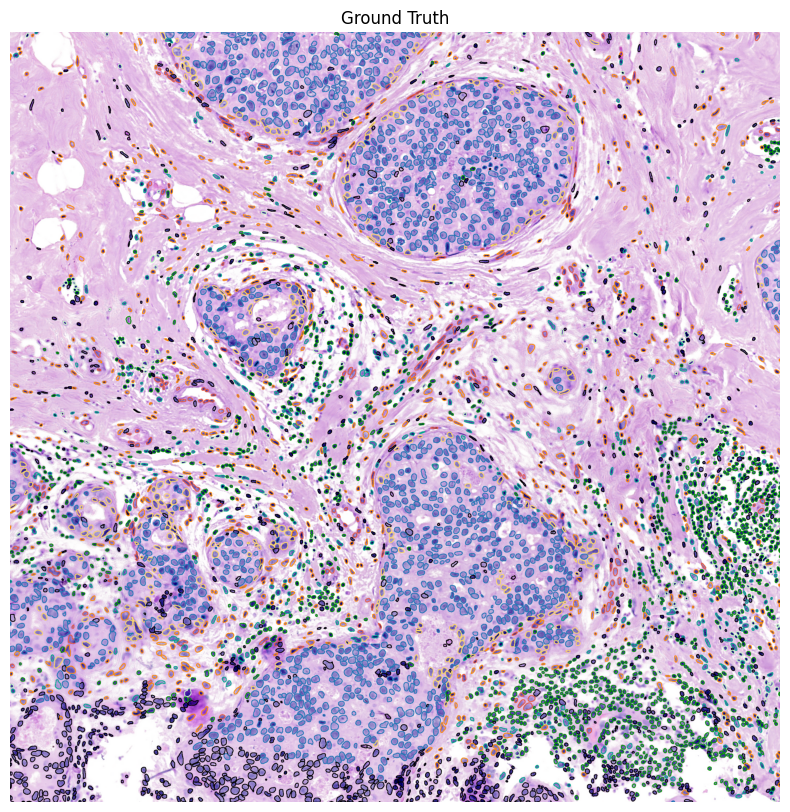

In [307]:
plotter_gt_filtered.plot_seg(window=window, show_visium=False, display=True, figsize=(10, 10), title="Ground Truth")

Sometimes filtering is very important because HistoCell predicts at tile-level. If tiles focus only on spots, then you have annotated cells exclusively at spot locations.

## Model predictions

In [49]:
analyzer_hc = PredAnalyzer(preds=histocell_pred,
                        spot_dict=spot_dict,
                        proportions=spot_prop_df,
                        adata=adata,
                        adata_name=adata_name,
                        image_path=image_path,
                        seg_dict=filtered_hovernet_dict,
                        ground_truth=filtered_ground_truth, 
                        image_dict=image_dict)

Loading predicted labels...
Loading true labels...
Use `add_attributes(history=your_history)` to add one.


In [50]:
from deconvplugin.analysis.postseg import StdVisualizer

plotter_hc = StdVisualizer(image_path, 
                        adata, 
                        adata_name, 
                        seg_dict=analyzer_hc.seg_dict_w_class,
                        color_dict=color_dict)

Visium data found.


In [44]:
window = ((18285, 17090), (200, 200))
fig = plotter_hc.plot_seg(window=window, show_visium=False, display=False, title="HistoCell", figsize=(4, 4))
fig.savefig(f"results/HistoCell/{adata_name}/fig/crop_3_types_histocell_{window[0][0]}_{window[0][1]}_{window[1][0]}.png", dpi=300, bbox_inches='tight')

In [51]:
window = ((17200, 16000), (3000, 3000)) #((3000, 20000), (2000, 2000))
fig = plotter_hc.plot_slide(window=window, spot_prop_df=analyzer_hc.predicted_proportions, show_visium=True, title='HistoCell', display=False, figsize=(10, 10))
fig.savefig(f"results/HistoCell/{adata_name}/fig/crop_7_types_histocell_{window[0][0]}_{window[0][1]}_{window[1][0]}_prop.png", dpi=300, bbox_inches='tight')

In [ ]:
# from utils import save_metrics_to_excel

# output_path = os.path.join(f'results/HistoCell/{adata_name}/{slide_name}', 'metrics.xlsx')

# metrics_cells = analyzer_hc.evaluate_cell_predictions(per_class=False)
# save_metrics_to_excel(metrics_cells, seed, output_path)

If you have spot information, you can also compute cell-type proportion metrics :

In [183]:
# metric_list = ['Pearson Correlation global', 'Spearman Correlation global', 'MSE global', 'MAE global']

# metrics_spots = analyzer_hc.evaluate_spot_predictions_global()
# metrics_spots = {k: v for k, v in metrics_spots.items() if k in metric_list}

# output_path = os.path.join(f'results/HistoCell/{adata_name}/{slide_name}', 'metrics_spots.xlsx')
# # save_metrics_to_excel(metrics_spots, seed, output_path)

# Quantitative comparison

Figure saved to results/HistoCell/Xenium_FFPE_Human_Breast_Cancer_Rep1/fig/barplot_benchmark_cells_7types.png


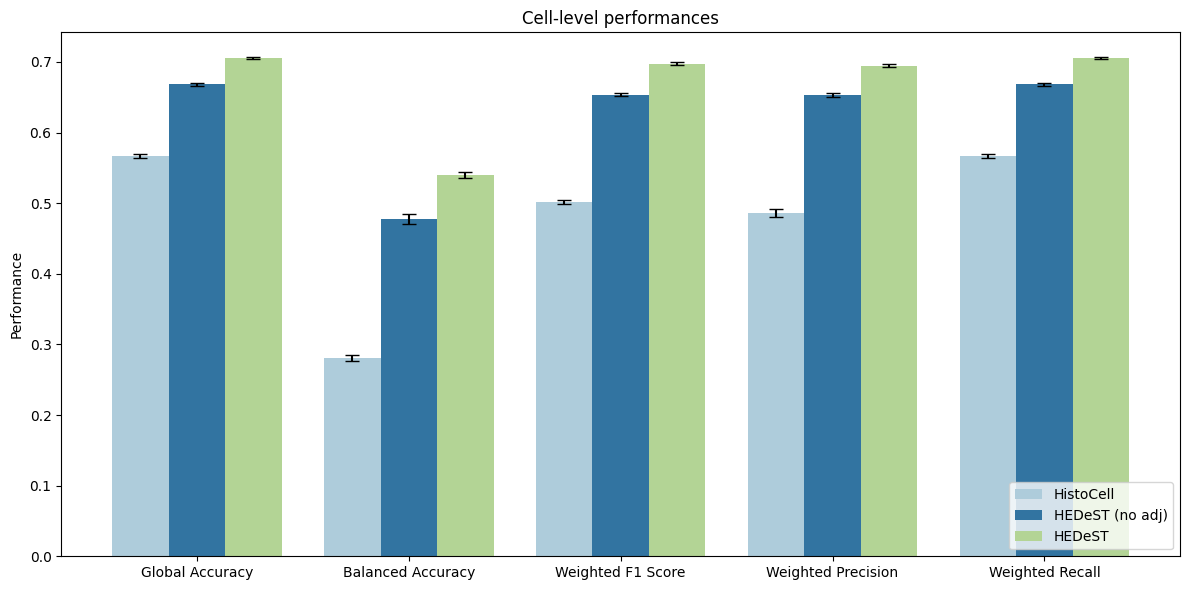

In [315]:
from utils import bar_plot_perf

# file_hovernet = "results/HoVerNet/Xenium_FFPE_Human_Breast_Cancer_Rep1/metrics.xlsx"
file_histocell = "results/HistoCell/Xenium_FFPE_Human_Breast_Cancer_Rep1/Rep1_256_hires/metrics.xlsx"
file_hedest_no_adj = "results/HistoCell/Xenium_FFPE_Human_Breast_Cancer_Rep1/HEDeST/7types/metrics_cells_best.xlsx"
file_hedest = "results/HistoCell/Xenium_FFPE_Human_Breast_Cancer_Rep1/HEDeST/7types/metrics_cells_best_adj.xlsx"

files_info = [
    (file_histocell, 'summary', 'HistoCell'),
    (file_hedest_no_adj, 'summary', 'HEDeST (no adj)'),
    (file_hedest, 'summary', 'HEDeST')
]

bar_plot_perf(files_info, level='cells', title='Cell-level performances', savefig='results/HistoCell/Xenium_FFPE_Human_Breast_Cancer_Rep1/fig/barplot_benchmark_cells_7types.png')

Figure saved to results/HistoCell/Xenium_FFPE_Human_Breast_Cancer_Rep1/fig/barplot_benchmark_slide_3types.png


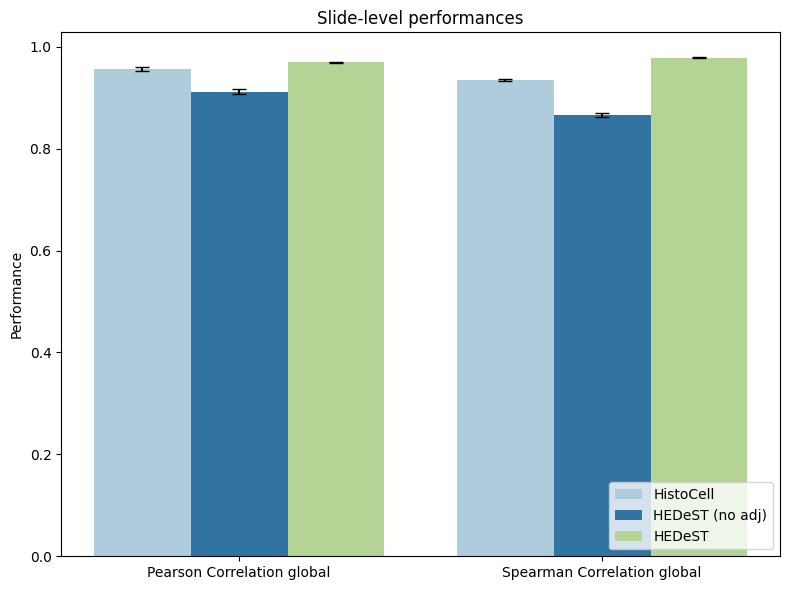

In [317]:
file_histocell = "results/HistoCell/Xenium_FFPE_Human_Breast_Cancer_Rep1/Rep1_256_3types/metrics_spots.xlsx"
file_hedest_no_adj = "results/HistoCell/Xenium_FFPE_Human_Breast_Cancer_Rep1/HEDeST/3types/metrics_slide_best.xlsx"
file_hedest = "results/HistoCell/Xenium_FFPE_Human_Breast_Cancer_Rep1/HEDeST/3types/metrics_slide_best_adj.xlsx"

files_info = [
    (file_histocell, 'summary', 'HistoCell'),
    (file_hedest_no_adj, 'summary', 'HEDeST (no adj)'),
    (file_hedest, 'summary', 'HEDeST')
]

bar_plot_perf(files_info, level='slide', title='Slide-level performances', figsize=(8, 6), savefig='results/HistoCell/Xenium_FFPE_Human_Breast_Cancer_Rep1/fig/barplot_benchmark_slide_3types.png')

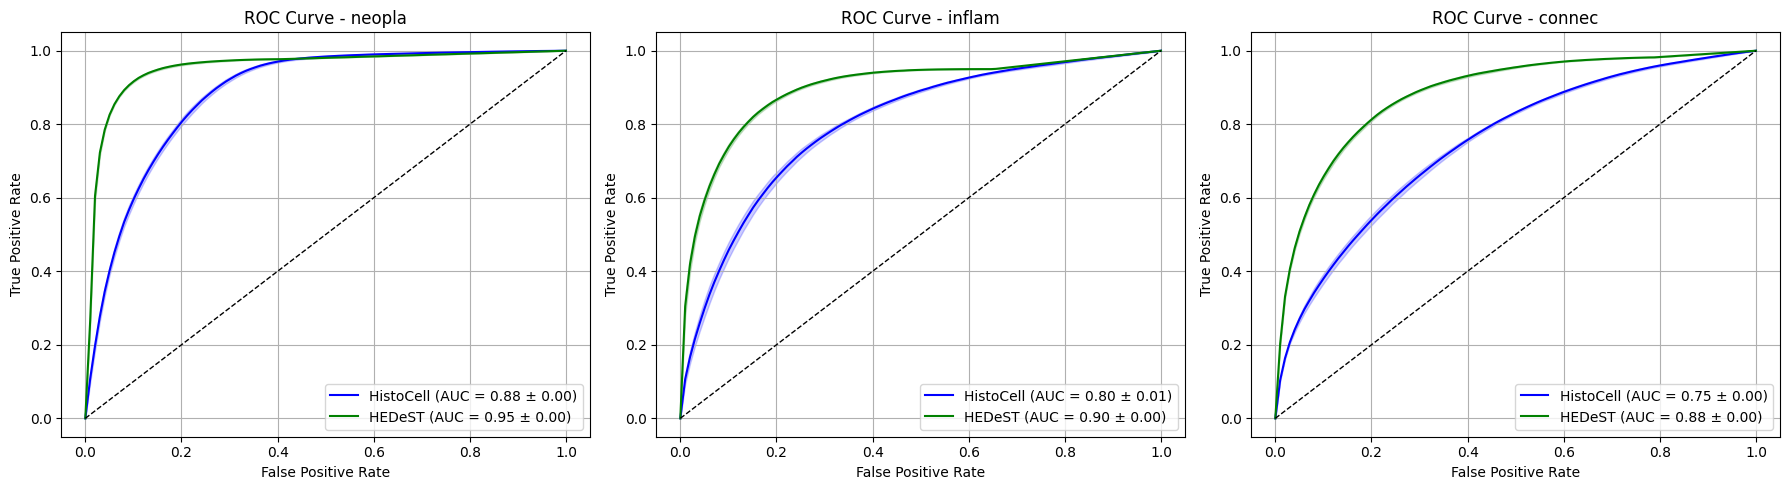

In [370]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import pickle

# Parameters
seeds = list(range(10))
cell_types = ['neopla', 'inflam', 'connec']

# Prepare a fixed FPR grid
fpr_grid = np.linspace(0, 1, 100)

# Initialize storage
results = {model: {ctype: [] for ctype in cell_types} for model in ['HistoCell', 'HEDeST']}
auc_scores = {model: {ctype: [] for ctype in cell_types} for model in ['HistoCell', 'HEDeST']}

for seed in seeds:
    # Load HistoCell
    histocell_path = f'results/HistoCell/{adata_name}/{slide_name}/seed_{seed}/pred_histocell.csv'
    histocell_pred = pd.read_csv(histocell_path, index_col=0)
    histocell_pred.index = histocell_pred.index.astype(str)

    # Filter GT
    filtered_gt = ground_truth[ground_truth.index.isin(histocell_pred.index)]
    filtered_gt = filtered_gt.reindex(histocell_pred.index)

    # Load HEDeST
    model_tag = f'model_quick_alpha_0.0_lr_0.0003_weights_False_divergence_l2_beta_1.0_seed_{seed}'
    model_dir = os.path.join('results/HistoCell/Xenium_FFPE_Human_Breast_Cancer_Rep1/HEDeST/3types', model_tag)
    with open(os.path.join(model_dir, 'info.pickle'), 'rb') as f:
        model_info = pickle.load(f)
    hedest_pred = model_info['preds']['pred_best_adjusted']
    hedest_pred = hedest_pred[hedest_pred.index.isin(filtered_gt.index)]
    hedest_pred = hedest_pred.reindex(filtered_gt.index)

    for ctype in cell_types:
        y_true = filtered_gt[ctype].values

        # HistoCell
        y_score_histo = histocell_pred[ctype].values
        fpr_h, tpr_h, _ = roc_curve(y_true, y_score_histo)
        auc_scores['HistoCell'][ctype].append(auc(fpr_h, tpr_h))
        tpr_interp_h = np.interp(fpr_grid, fpr_h, tpr_h)
        tpr_interp_h[0] = 0.0
        results['HistoCell'][ctype].append(tpr_interp_h)

        # HEDeST
        y_score_hedest = hedest_pred[ctype].values
        fpr_e, tpr_e, _ = roc_curve(y_true, y_score_hedest)
        auc_scores['HEDeST'][ctype].append(auc(fpr_e, tpr_e))
        tpr_interp_e = np.interp(fpr_grid, fpr_e, tpr_e)
        tpr_interp_e[0] = 0.0
        results['HEDeST'][ctype].append(tpr_interp_e)

# Plotting
plt.figure(figsize=(18, 5))
for i, ctype in enumerate(cell_types):
    plt.subplot(1, 3, i+1)

    for model, color in zip(['HistoCell', 'HEDeST'], ['blue', 'green']):
        tprs = np.array(results[model][ctype])
        mean_tpr = tprs.mean(axis=0)
        std_tpr = tprs.std(axis=0)
        mean_auc = np.mean(auc_scores[model][ctype])
        std_auc = np.std(auc_scores[model][ctype])

        plt.plot(fpr_grid, mean_tpr, color=color,
                 label=f'{model} (AUC = {mean_auc:.2f} ± {std_auc:.2f})')
        plt.fill_between(fpr_grid, mean_tpr - std_tpr, mean_tpr + std_tpr,
                         color=color, alpha=0.2)

    plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
    plt.title(f'ROC Curve - {ctype}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)

plt.tight_layout()
plt.savefig("results/HistoCell/Xenium_FFPE_Human_Breast_Cancer_Rep1/fig/AUC_curves_benchmark_3types.png", dpi=300, bbox_inches='tight')
plt.show()